In [1]:
import os
import operator
import json
from typing import Annotated, TypedDict, Literal, List
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END
from langchain_chroma import Chroma
from langchain_community.utilities import SQLDatabase

# Import ReAct Agent
from React_agent import run_react_agent
# Import Ticket Tool for direct emergency escalation
from ticket_service import create_ticket_tool

load_dotenv()
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')

# =============================================================================
# 1. SETUP RESOURCES (Adopting Simple_agent.py Logic)
# =============================================================================

DB_PATH = "./Database/NextGen.db"
CHROMA_DB_DIR = "./sop_embeddings/chroma_store"

# Re-establishing connections for the Fast Agent (Orchestrator local use)
if not os.path.exists(DB_PATH):
    # Fallback if DB doesn't exist (Simple_agent.py usually creates this)
    print("⚠️ Warning: NextGen.db not found. Ensure Simple_agent.py has run once.")

db = SQLDatabase.from_uri(f"sqlite:///{DB_PATH}")

embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001", api_key=GOOGLE_API_KEY)
# Connect to existing persistence if available, else standard fallback
if os.path.exists(CHROMA_DB_DIR):
    vectorstore = Chroma(persist_directory=CHROMA_DB_DIR, embedding_function=embeddings)
    sop_retriever = vectorstore.as_retriever()
else:
    print("⚠️ Warning: Chroma DB not found. Fast Agent RAG will be limited.")
    # Mock retriever for safety if file missing
    class MockRetriever:
        def invoke(self, x): return []
    sop_retriever = MockRetriever()

llm_router = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

# =============================================================================
# 2. STATE & ANALYSIS MODELS
# =============================================================================

class OrchestratorState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    analysis: dict
    final_response: str
    customer_id: str

class QueryDeepAnalysis(BaseModel):
    """
    Advanced 7-Factor Analysis for Routing.
    """
    # 1. Complexity
    complexity_score: int = Field(description="1-10 Score. 1=Hi/Bye, 10=Multi-step deductive reasoning needed.")
    # 2. Sentiment
    sentiment_category: Literal[
        "Joy", "Neutral", "Confusion", "Frustration", "Anger", "Rage", "Anxiety", "Urgency"
    ] = Field(description="Primary emotion category.")
    sentiment_intensity: int = Field(description="1-10 Intensity of emotion.")
    # 3. Intent
    intent: Literal["General_Info", "Billing_Status", "Technical_Issue", "Complaint", "Sales"]
    # 4. Knowledge Source
    requires_multi_source: bool = Field(description="True if query needs comparison between DB and SOP.")
    # 5. Urgency
    urgency_level: Literal["Low", "Medium", "High", "Critical"]
    # 7. Reasoning
    requires_react: bool = Field(description="True if the answer isn't a simple lookup but requires logic (e.g., 'Why is my bill high?').")

# =============================================================================
# 3. NODES
# =============================================================================

def brain_classifier_node(state: OrchestratorState):
    """
    The BRAIN: Analyzes the query using the 7 decision factors.
    """
    print("\n🧠 ORCHESTRATOR: Analyzing Query Dimensions...")
    query = state["messages"][-1].content
    
    system_prompt = """You are the Decision Core of an AI Helpdesk. 
    Analyze the user query deeply based on:
    1. Complexity (Is it a simple lookup or a 'Why' question?)
    2. Sentiment (Detect subtle cues of frustration or rage).
    3. Intent.
    
    OUTPUT RULES:
    - If user asks 'Why', 'Explain', 'Compare', or has a complex technical issue -> requires_react = True.
    - If user asks 'What is', 'How to', 'Status of' -> requires_react = False.
    - If Sentiment is 'Rage' or Urgency is 'Critical' -> Mark accordingly for escalation.
    """
    
    structured_llm = llm_router.with_structured_output(QueryDeepAnalysis)
    prompt = ChatPromptTemplate.from_messages([("system", system_prompt), ("human", "{query}")])
    
    analysis_result = prompt | structured_llm
    analysis = analysis_result.invoke({"query": query})
    
    print(f"   📊 Analysis: Complexity={analysis.complexity_score}, Sentiment={analysis.sentiment_category}, ReAct={analysis.requires_react}")
    return {"analysis": analysis.dict()}

def fast_agent_node(state: OrchestratorState):
    """
    Fast Path: Uses RAG + Simple DB Lookup (Logic adapted from Simple_agent.py).
    """
    print("\n⚡ FAST AGENT: Executing Quick Lookup...")
    query = state["messages"][-1].content
    customer_id = state.get("customer_id", "CUST_001") # Default for demo
    
    # 1. RAG Lookup
    docs = sop_retriever.invoke(query)
    sop_context = "\n".join([d.page_content for d in docs]) if docs else "No SOP found."
    
    # 2. Simple DB Lookup (LLM generates SQL for simple retrieval)
    db_context = "No DB Access needed for this query."
    if state["analysis"]["intent"] in ["Billing_Status", "Technical_Issue"]:
        try:
            # Quick "Text-to-SQL" for simple retrieval
            sql_prompt = f"Write a SQLite SELECT query for customer_id='{customer_id}' based on: {query}. Schema: {db.get_table_info()}"
            sql_query = llm_router.invoke(sql_prompt).content.replace("```sql", "").replace("```", "").strip()
            if "SELECT" in sql_query.upper():
                db_results = db.run(sql_query)
                db_context = f"DB Data: {db_results}"
        except:
            db_context = "DB Lookup Failed."

    # 3. Synthesis
    synth_prompt = f"""You are a helpful assistant.
    User Query: {query}
    SOP Context: {sop_context}
    Account Data: {db_context}
    
    Answer the user politely and concisely in an Empathetic way.
    """
    response = llm_router.invoke(synth_prompt).content
    return {"final_response": response}

def react_agent_node(state: OrchestratorState):
    """
    Slow Path: Routes to the ReAct Agent for deep thinking.
    """
    print("\n🐢 REACT AGENT: Delegating to Reasoner...")
    query = state["messages"][-1].content
    
    # Call the external ReAct agent
    response = run_react_agent(query)
    
    return {"final_response": response}

def emergency_ticket_node(state: OrchestratorState):
    """
    Critical Path: Bypasses AI resolution for Rage/Critical issues.
    """
    print("\n🚨 CRITICAL ESCALATION: Creating Ticket Immediately...")
    query = state["messages"][-1].content
    sentiment = state["analysis"]["sentiment_category"]
    
    ticket_msg = create_ticket_tool(
        description=f"AUTO-ESCALATION ({sentiment}): {query}", 
        priority="Urgent"
    )
    
    response = f"I sense that you are extremely upset ({sentiment}). I have bypassed our standard AI and created an urgent ticket for a human supervisor.\n{ticket_msg}"
    return {"final_response": response}

# =============================================================================
# 4. ROUTING LOGIC
# =============================================================================

def router(state: OrchestratorState):
    analysis = state["analysis"]
    
    # 1. Critical Safety Valve
    if analysis["sentiment_category"] == "Rage" or analysis["urgency_level"] == "Critical":
        return "emergency_ticket"
    
    # 2. Complexity Check
    if analysis["requires_react"] or analysis["complexity_score"] >= 7:
        return "react_agent"
    
    # 3. Default Fast Path
    return "fast_agent"

# =============================================================================
# 5. GRAPH CONSTRUCTION
# =============================================================================

workflow = StateGraph(OrchestratorState)

workflow.add_node("Orchestrator", brain_classifier_node)
workflow.add_node("fast_agent", fast_agent_node)
workflow.add_node("react_agent", react_agent_node)
workflow.add_node("emergency_ticket", emergency_ticket_node)

workflow.set_entry_point("Orchestrator")

workflow.add_conditional_edges(
    "Orchestrator",
    router,
    {
        "fast_agent": "fast_agent",
        "react_agent": "react_agent",
        "emergency_ticket": "emergency_ticket"
    }
)

workflow.add_edge("fast_agent", END)
workflow.add_edge("react_agent", END)
workflow.add_edge("emergency_ticket", END)

orchestrator_app = workflow.compile()

# =============================================================================
# 6. RUNNER
# =============================================================================

# if __name__ == "__main__":
#     print(">>> 🧠 ORCHESTRATOR ONLINE")
    
#     # Test 1: Simple (Fast Agent)
#     print("\n--- TEST 1: Simple Info ---")
#     res1 = orchestrator_app.invoke({"messages": [HumanMessage(content="What are the customer service hours?")], "customer_id": "CUST_001"})
#     print(f"Bot: {res1['final_response']}")
    
#     # Test 2: Complex (ReAct Agent)
#     print("\n--- TEST 2: Complex Reasoning ---")
#     res2 = orchestrator_app.invoke({"messages": [HumanMessage(content="Why is my bill higher than last month? I didn't change my plan.")], "customer_id": "CUST_002"})
#     print(f"Bot: {res2['final_response']}")
    
#     # Test 3: Rage (Emergency Ticket)
#     print("\n--- TEST 3: Rage Escalation ---")
#     res3 = orchestrator_app.invoke({"messages": [HumanMessage(content="This service is garbage! I have been waiting for 5 hours! I want to sue you!")], "customer_id": "CUST_001"})
#     print(f"Bot: {res3['final_response']}")

d:\Empathetic-AI-\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Empathetic-AI-\venv\Lib\site-packages\pydantic\_internal\_config.py:383: UserWarning: Valid config keys have changed in V2:
* 'orm_mode' has been renamed to 'from_attributes'
  warnings.warn(message, UserWarning)


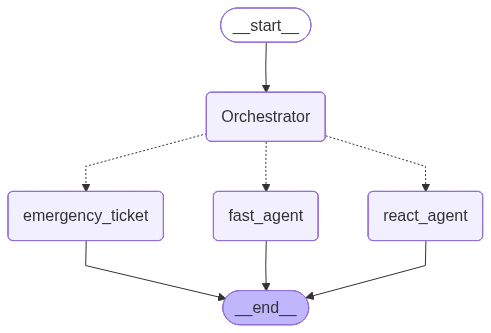

In [2]:
from IPython.display import display, Image

display(Image(orchestrator_app.get_graph().draw_mermaid_png()))

In [3]:
import sqlite3
import operator
import os
import shutil
from typing import Annotated, TypedDict, Union, List, Literal
from dotenv import load_dotenv
# from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_community.utilities import SQLDatabase
from langchain_chroma import Chroma
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import CharacterTextSplitter
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, END
from pydantic import BaseModel, Field

load_dotenv()

# !!! IMPORTANT: Set your OpenAI API Key here !!!
# os.environ["OPENAI_API_KEY"] = "sk-..."
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')

# =============================================================================
# 1. SETUP: Database & SOP Loading (Based on Uploaded PDFs)
# =============================================================================

DB_PATH = "./Database/NextGen.db"
CHROMA_DB_DIR = "./sop_embeddings/chroma_store"


def setup_database_schema():
    """Creates the exact schema defined in 'logical_model.pdf'."""
    if not os.path.exists(DB_PATH):
        conn = sqlite3.connect(DB_PATH)
        c = conn.cursor()

        # 1. CUSTOMERS
        c.execute('''CREATE TABLE IF NOT EXISTS customers (
            customer_id TEXT PRIMARY KEY, name TEXT, phone_number TEXT, 
            account_status TEXT, kyc_status TEXT, pincode TEXT)''')

        # 2. OUTAGE_AREAS (For Slow Internet SOP)
        c.execute('''CREATE TABLE IF NOT EXISTS outage_areas (
            outage_id TEXT PRIMARY KEY, city TEXT, pincode TEXT, 
            issue_description TEXT, expected_resolution TEXT)''')

        # 3. CUSTOMER_USAGE (For Usage Checks)
        c.execute('''CREATE TABLE IF NOT EXISTS customer_usage (
            usage_id TEXT PRIMARY KEY, customer_id TEXT, date TEXT, 
            mobile_data_used_gb REAL, plan_limit_gb REAL)''')

        # 4. INVOICES (For Billing Dispute SOP)
        c.execute('''CREATE TABLE IF NOT EXISTS invoices (
            invoice_id TEXT PRIMARY KEY, customer_id TEXT, amount REAL, 
            due_date TEXT, paid_status TEXT, billing_period TEXT)''')

        # 5. TRANSACTIONS (For Wrong Recharge SOP)
        c.execute('''CREATE TABLE IF NOT EXISTS transactions (
            txn_id TEXT PRIMARY KEY, customer_id TEXT, amount REAL, 
            txn_date TEXT, transaction_status TEXT)''')

        # 6. SUBSCRIPTIONS (For Roaming/Plan Benefits SOP)
        c.execute('''CREATE TABLE IF NOT EXISTS subscriptions (
            subscription_id TEXT PRIMARY KEY, customer_id TEXT, plan_id TEXT, 
            status TEXT, start_date TEXT)''')

        # --- Insert Mock Data for Testing ---
        # Case 1: CUST_001 (Slow Internet, Outage)
        c.execute(
            "INSERT OR REPLACE INTO customers VALUES ('CUST_001', 'Alice', '555-0101', 'Active', 'Verified', '10001')")
        c.execute("INSERT OR REPLACE INTO outage_areas VALUES ('OUT_01', 'New York', '10001', 'Fiber Cut', '4 Hours')")

        # Case 2: CUST_002 (Billing Dispute)
        c.execute("INSERT OR REPLACE INTO customers VALUES ('CUST_002', 'Bob', '555-0102', 'Active', 'Verified', '10002')")
        c.execute(
            "INSERT OR REPLACE INTO invoices VALUES ('INV_001', 'CUST_002', 150.00, '2023-11-01', 'Unpaid', 'Oct-2023')")

        conn.commit()
        conn.close()

    db_connection = SQLDatabase.from_uri(f"sqlite:///{DB_PATH}")
    print("✅ Database Schema & Mock Data Ready.")

    return db_connection


def setup_vector_store():
    """Loads the SOP content from your PDFs into the Vector Store."""
    embedding_function = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001", api_key=GOOGLE_API_KEY)

    # Check persistence
    if os.path.exists(CHROMA_DB_DIR) and os.path.isdir(CHROMA_DB_DIR):
        print("✅ Found existing Vector Store.")
        return Chroma(persist_directory=CHROMA_DB_DIR, embedding_function=embedding_function).as_retriever()

    print("⚙️ Building Vector Store from SOP Content...")

    # Content extracted from your uploaded PDFs
    sop_content = [
        # SLOW INTERNET SOP
        """SOP: Handling Slow Internet Issue.
        Step 1: Acknowledge Complaint.
        Step 2: Verify Account Status. Check CUSTOMERS table for account_status='Active'.
        Step 3: Check for Network Outage. Query OUTAGE_AREAS using customer's pincode. SQL: SELECT * FROM outage_areas WHERE pincode = '...';
        If outage exists, inform resolution time.
        Step 4: Validate Usage. Check CUSTOMER_USAGE. If data_used > plan_limit, suggest upgrade.""",

        # ROUTER CONFIG SOP
        """SOP: Handling Router Configuration.
        Step 1: Verify Account Status in CUSTOMERS table.
        Step 2: Validate Router Settings.
        Step 3: Restart Router.
        Step 4: If unresolved, escalate to Technical Team.""",

        # BILLING DISPUTE SOP (Master SOP)
        """SOP: Billing Dispute.
        Purpose: Resolve incorrect billing amounts.
        Step 1: Verify account and invoice. Check INVOICES table. SQL: SELECT * FROM invoices WHERE customer_id='...';
        Step 2: Validate billing period and amount.
        Step 3: Escalate to Billing Team if mismatch found.""",

        # GENERAL INFO (For General Inquiries)
        """Customer Service Hours: 8 AM to 8 PM EST, Monday through Friday.
        To request a refund, please visit the 'Support' section in the mobile app."""
    ]

    vectorstore = Chroma.from_texts(sop_content, embedding=embedding_function, persist_directory=CHROMA_DB_DIR)
    return vectorstore.as_retriever()


db = setup_database_schema()
sop_retriever = setup_vector_store()

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    api_key=GOOGLE_API_KEY,
    temperature=0.3
)

# =============================================================================
# 2. STATE & DEFINITIONS
# =============================================================================

# Updated Route Options based on your requirement
# greeting: Chit-chat
# general_inquiry: SOP only (How-to, Policies)
# db_inquiry: DB only (My balance, My bill)
# troubleshoot: Hybrid (Slow internet, Billing dispute)

ROUTE_OPTIONS = Literal["greeting", "general_inquiry", "db_inquiry", "troubleshoot"]
SENTIMENT_OPTIONS = Literal["Angry", "Happy", "Sad", "Neutral", "Frustrated"]


class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    sentiment: SENTIMENT_OPTIONS
    route_intent: ROUTE_OPTIONS
    customer_id: str
    tool_output: str  # Holds data from DB or SOP


# --- Pydantic Models ---
class SentimentResponse(BaseModel):
    emotion: SENTIMENT_OPTIONS = Field(description="The emotional tone of the user's text.")


class RouteResponse(BaseModel):
    step: ROUTE_OPTIONS = Field(description="The classification of the user query.")


class HybridResponse(BaseModel):
    needs_sql: bool = Field(description="True if the SOP step requires checking the database.")
    sql_query: str = Field(description="The SQL query if needed, else empty string.")
    direct_answer: str = Field(description="The answer if no SQL is needed.")


class SqlQuery(BaseModel):
    query: str = Field(description="Valid SQL query.")


# =============================================================================
# 3. NODE IMPLEMENTATIONS
# =============================================================================

def sentiment_agent(state: AgentState):
    """Detects emotion using LLM (No Mocking)."""
    print("\n--- [Node] Sentiment Agent ---")
    user_text = state["messages"][-1].content

    structured_llm = llm.with_structured_output(SentimentResponse)
    system_prompt = "Classify the user's emotion. If they are asking for help politely, it is Neutral. If they mention waiting, errors, or overcharging, check for Anger/Frustration."

    chain = ChatPromptTemplate.from_messages([("system", system_prompt), ("human", "{text}")]) | structured_llm
    result = chain.invoke({"text": user_text})

    print(f"   Detected Sentiment: {result.emotion}")
    return {"sentiment": result.emotion}


def router_node(state: AgentState):
    """Classifies query into Greeting, General, Direct DB, or Troubleshoot."""
    print("--- [Node] Router ---")
    user_text = state["messages"][-1].content

    structured_llm = llm.with_structured_output(RouteResponse)

    system_prompt = """Classify the user query into one of these intents:
    1. 'greeting': Hello, Hi, Bye, Thanks.
    2. 'general_inquiry': General questions about policies, hours, or how-to guides (No personal data needed).
    3. 'db_inquiry': Specific questions about the user's current account status, balance, or specific bill amount.
    4. 'troubleshoot': Complex issues like 'slow internet', 'billing dispute', 'roaming not working', 'router config'.
    """

    chain = ChatPromptTemplate.from_messages([("system", system_prompt), ("human", "{query}")]) | structured_llm
    result = chain.invoke({"query": user_text})

    print(f"   Routing to: {result.step.upper()}")
    return {"route_intent": result.step}


def greeting_node(state: AgentState):
    """Handles Chit-Chat."""
    print("--- [Node] Greeting Agent ---")
    return {"tool_output": "Greeting"}


def general_inquiry_node(state: AgentState):
    """Handles General SOP questions (No DB)."""
    print("--- [Node] General Inquiry Agent ---")
    user_text = state["messages"][-1].content

    docs = sop_retriever.invoke(user_text)
    context = "\n".join([d.page_content for d in docs])

    return {"tool_output": f"SOP Info: {context}"}


def db_agent(state: AgentState):
    """Handles Direct DB inquiries."""
    print("--- [Node] Direct DB Agent ---")
    user_text = state["messages"][-1].content
    cust_id = state.get("customer_id")

    structured_llm = llm.with_structured_output(SqlQuery)
    prompt = f"Schema: {db.get_table_info()}. Write SQL for customer_id='{cust_id}' based on: {user_text}"
    result = (ChatPromptTemplate.from_template(prompt) | structured_llm).invoke({})
    print(f"SQL Query: {result.query}")
    try:
        data = db.run(result.query)
        output = f"DB Record: {data}"
    except Exception as e:
        output = f"Error: {e}"

    return {"tool_output": output}


def sop_troubleshooter_node(state: AgentState):
    """Hybrid Agent for Complex Issues (SOP + DB)."""
    print("--- [Node] Hybrid Troubleshooter ---")
    user_text = state["messages"][-1].content
    cust_id = state.get("customer_id")

    # 1. Retrieve SOP
    docs = sop_retriever.invoke(user_text)
    context = "\n".join([d.page_content for d in docs])

    # 2. Analyze: Needs SQL?
    structured_llm = llm.with_structured_output(HybridResponse)
    system_prompt = f"""You are a Technical Troubleshooter.
    Context (SOP): {context}
    Database Schema: {db.get_table_info()}

    Task: If the SOP suggests checking a table (OUTAGE_AREAS, INVOICES, etc.) for this issue, write the SQL query for customer_id='{cust_id}'.
    Otherwise, return needs_sql=False.
    """

    chain = ChatPromptTemplate.from_messages([("system", system_prompt), ("human", "{query}")]) | structured_llm
    analysis = chain.invoke({"query": user_text})

    final_context = f"SOP Guidelines: {context}\n"

    if analysis.needs_sql:
        print(f"   ⚠️ Executing SQL: {analysis.sql_query}")
        try:
            sql_result = db.run(analysis.sql_query)
            final_context += f"\nLIVE DATA: {sql_result}"
        except Exception as e:
            final_context += f"\nDB Error: {e}"
    else:
        print("   ℹ️ Pure Text Answer.")

    return {"tool_output": final_context}


def response_synthesizer(state: AgentState):
    """The EMPATHY Layer."""
    print("--- [Node] Empathetic Synthesizer ---")
    intent = state["route_intent"]
    raw_data = state["tool_output"]
    sentiment = state["sentiment"]
    user_text = state["messages"][-1].content

    # 1. System Prompt construction based on Sentiment
    base_prompt = "You are a helpful Telecom Assistant."

    if sentiment in ["Angry", "Frustrated"]:
        tone_instruction = "The user is upset. Start with a sincere apology. Be concise but reassuring. Acknowledge their frustration."
    elif sentiment == "Happy":
        tone_instruction = "The user is happy. Respond with high energy and gratitude."
    else:
        tone_instruction = "The user is neutral. Be professional, polite, and direct."

    # 2. Intent-specific instructions
    if intent == "greeting":
        context_instruction = "Reply purely to the greeting. Keep it short."
    elif intent == "troubleshoot":
        context_instruction = f"Use the provided SOP/Data to explain the issue. If there is an outage/error shown in the data, explain it clearly. \nData: {raw_data}"
    else:
        context_instruction = f"Answer using this information: {raw_data}"

    full_prompt = f"{base_prompt}\n{tone_instruction}\n{context_instruction}"

    msg = llm.invoke(f"{full_prompt}\n\nUser Query: {user_text}")
    return {"messages": [msg]}


# =============================================================================
# 4. GRAPH CONSTRUCTION
# =============================================================================

workflow = StateGraph(AgentState)

# Add Nodes
workflow.add_node("sentiment_scanner", sentiment_agent)
workflow.add_node("router", router_node)
workflow.add_node("greeting_agent", greeting_node)
workflow.add_node("general_agent", general_inquiry_node)
workflow.add_node("db_agent", db_agent)
workflow.add_node("hybrid_agent", sop_troubleshooter_node)
workflow.add_node("synthesizer", response_synthesizer)

# Set Entry
workflow.set_entry_point("sentiment_scanner")
workflow.add_edge("sentiment_scanner", "router")

# Routing Logic
workflow.add_conditional_edges(
    "router",
    lambda x: x["route_intent"],
    {
        "greeting": "greeting_agent",
        "general_inquiry": "general_agent",
        "db_inquiry": "db_agent",
        "troubleshoot": "hybrid_agent"
    }
)

# All agents point to Synthesizer
workflow.add_edge("greeting_agent", "synthesizer")
workflow.add_edge("general_agent", "synthesizer")
workflow.add_edge("db_agent", "synthesizer")
workflow.add_edge("hybrid_agent", "synthesizer")
workflow.add_edge("synthesizer", END)

app = workflow.compile()

# =============================================================================
# 5. TEST SCENARIOS
# =============================================================================

# if __name__ == "__main__":
#     print(">>> 🤖 TELECOM BOT: EMPATHY & CLASSIFICATION ENABLED")

#     while True:
#         user_input = input("Enter your query: ")
#         if user_input.lower() == 'exit':
#             break
#         # TEST 1: General Inquiry (SOP only, No DB)
#         print("\n--- TEST 1: General Inquiry (Neutral) ---")
#         res1 = app.invoke(
#             {"messages": [HumanMessage(content=user_input)], "customer_id": "1"})
#         print(f"Bot: {res1['messages'][-1].content}")

        # # TEST 2: Billing Dispute (Angry, Hybrid)
        # # CUST_002 has an 'Unpaid' invoice in the mock data
        # print("\n--- TEST 2: Billing Dispute (Angry) ---")
        # res2 = app.invoke(
        #     {"messages": [HumanMessage(content="I am furious! Why is my bill unpaid when I sent the check??")],
        #      "customer_id": "CUST_002"})
        # print(f"Bot: {res2['messages'][-1].content}")

✅ Database Schema & Mock Data Ready.
✅ Found existing Vector Store.


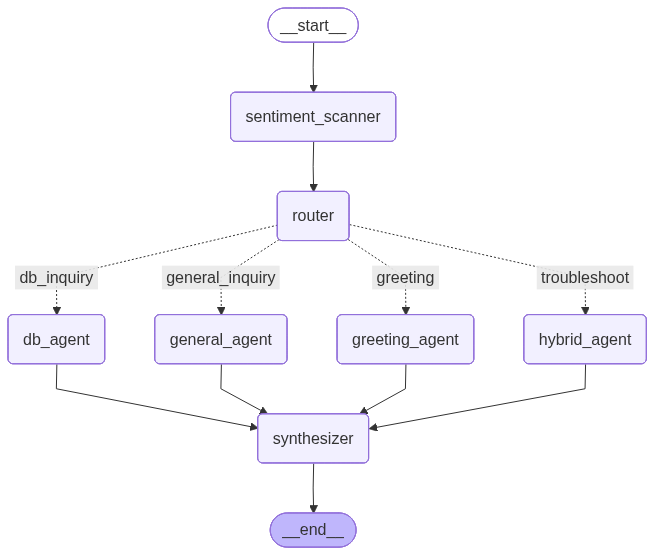

In [4]:
from IPython.display import display, Image 

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
import os
import sqlite3
from typing import List
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool
from langchain.agents import create_agent
from langchain_classic import hub  # ← CHANGED: langchain-classic for hub
from ticket_service import create_ticket_tool

load_dotenv()
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')

# --- CONFIGURATION ---
DB_PATH = "./Database/NextGen.db"  # Path to the Telecom Data (from Simple_agent)

# --- TOOLS FOR REACT AGENT ---

@tool
def query_telecom_db(query: str):
    """
    Executes a read-only SQL query against the Telecom Database (NextGen.db).
    Use this to look up customer plans, outages, invoices, and transactions.
    Tables: customers, outage_areas, customer_usage, invoices, transactions, subscriptions.
    Input must be a valid SQLite SELECT query.
    """
    try:
        # Security check (simple)
        if "drop" in query.lower() or "delete" in query.lower() or "update" in query.lower():
            return "Error: Read-only access allowed."
            
        conn = sqlite3.connect(DB_PATH)
        cursor = conn.cursor()
        cursor.execute(query)
        columns = [description[0] for description in cursor.description]
        results = cursor.fetchall()
        conn.close()
        
        if not results:
            return "No data found."
            
        return f"Schema: {columns}\nData: {results}"
    except Exception as e:
        return f"Database Error: {e}"

@tool
def escalate_issue(issue_summary: str, priority: str):
    """
    Escalates the issue to a human agent by creating a support ticket.
    Use this if you cannot resolve the issue after analyzing the database.
    """
    # Mapping priority to Issue Type implicitly for simplicity
    issue_type = 2 if "technical" in issue_summary.lower() else 3 if "bill" in issue_summary.lower() else 1
    return create_ticket_tool(description=issue_summary, priority=priority, issue_type_id=issue_type)

# --- AGENT CONSTRUCTION ---

def build_react_agent():
    llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.2)  # ← Fixed typo
    
    tools = [query_telecom_db, escalate_issue]
    
    # Pull ReAct prompt from Hub (works with v1)
    prompt = hub.pull("hwchase17/react")
    
    # Create custom system prompt for v1 agent
    system_prompt = """
    You are a Senior Level 3 Support Agent.
    Your job is to perform Root Cause Analysis.
    
    1. **Think**: Break down the user's complaint.
    2. **Investigate**: Use 'query_telecom_db' to check tables (customers, invoices, outage_areas, etc.).
    3. **Analyze**: Compare the user's claim against the DB data.
    4. **Act**: If you find the root cause, explain it. If it's a valid system error you can't fix, use 'escalate_issue'.
    
    Example: User says "Internet slow". 
    - Check 'customers' for status.
    - Check 'outage_areas' for their pincode.
    - Check 'customer_usage' for data caps.
    
    Always use tools before responding. Think step-by-step.
    """
    
    # v1.0 create_agent API
    agent = create_agent(
        llm, 
        tools, 
        system_prompt=system_prompt  # ← v1 uses system_prompt parameter
    )
    
    return agent  # ← v1 agent is directly invocable, no AgentExecutor needed

# Shared instance
react_agent = build_react_agent()  # ← Renamed for clarity

def run_react_agent(user_query: str):
    """Entry point for the Orchestrator."""
    print(f"\n🧠 [ReAct Agent] Starting deep analysis for: {user_query}")
    # v1.0 input format uses messages
    result = react_agent.invoke({
        "messages": [{"role": "user", "content": user_query}]
    })
    # Extract final output from messages
    return result["messages"][-1].content  # ← v1 returns AIMessage in messages list

In [9]:
from IPython.display import display, Image

display(Image(workflow.get_graph().draw_mermaid_png()))

AttributeError: 'StateGraph' object has no attribute 'get_graph'